# Core, HSI_loader.ipynb

Basically, my program follow these steps :

1. load the csv
2. train 2 models to predict the melanin and BlSDBN, X is [:, 46:67]
3. Evaluate 2 models on the given csv (train test split, cross_validation)
   1. use MSE, R2, etc for the performance metric
   2. performance result is written in the report
4. load (Data_Mike/.mat)['R1'][:,:,0:42:2]
5. reshape to (202 * 202, 21), replace inf to 0
6. use the trained model to predict mel and BlSDBN from .mat file
7. save these 2 predicted results, and reshape them back to (202,202)
8. plot these 2 predicted results
9. Go back to step 2, tune the hyper parameters of 2 models, try to get as better models as possible.
10. Code is done, the readme report includes:
   1. The performance results when training on the given .csv
   2. Compare images predicted by our best model(i.e. with hyper parameters), and the provided images in the A3_Framework folder
      1. make biology inference, and make the qualitative comparison of images
      

We just use different models for core, completion and challenge. Others are the same

In [31]:
from scipy.io import loadmat
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import csv
import time
import sys
import torch
import torchmetrics  # metrics like accuracy, recall, etc
import torch.nn as nn
# from torch import nn
from torch.nn.modules.container import Sequential
import torch.nn.functional as F


from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from copy import deepcopy


DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
print("we can use:", DEVICE, "to run the Model ")

we can use: cpu to run the Model 


In [32]:

#dataset_path = sys.argv[1];
#folder = sys.argv[2];
#filename = sys.argv[3];

dataset_path = "MC_Modeled_spectra.csv"; # monte carlo dataset 
folder = "Data_Mike" + "/";
filename = "R_(1measurement)_normalized_NoGap[202,202,79].mat"; # hyperspectral image(pixels, wavelengths)


HSI_mat_data_file_to_load = folder + filename; # HSI file
# copy from the given code, it will be saved by using np.save() with the format of .npy
saved_Results_file = folder + filename + dataset_path; 
provided_npy_file = "R_(1measurement)_normalized_NoGap[202,202,79].matData_small.csv.npy"
Results_from_given_npy = np.load(provided_npy_file, allow_pickle=True)
print("Results.shape", Results_from_given_npy.shape)

Hyperspectra_data = loadmat(HSI_mat_data_file_to_load)['R1'];
(x_total, y_total, wavelenght) = Hyperspectra_data.shape;
print("Hyperspectral data: x_total:", x_total, "y_total:", y_total, "wavelengh:", wavelenght);

Hyperspectra_data_resized = Hyperspectra_data[:,:, 0:42:2]; # Get from 510 to 720 nm with 10nm step size
print(f"Resized Hyperspectra data shape : {Hyperspectra_data_resized.shape}")


Results.shape (202, 202, 11)
Hyperspectral data: x_total: 202 y_total: 202 wavelengh: 79
Resized Hyperspectra data shape : (202, 202, 21)


In [ ]:
def mse_loss(y_pred, y_true):
    squared_error = (y_pred - y_true) ** 2
    sum_squared_error = np.sum(squared_error)
    mse_loss = sum_squared_error / y_true.size
    sse = sum((y_true - y_pred)**2)
    tse = (len(y_true) - 1) * np.var(y_true, ddof=1)
    r2_score = 1 - (sse / tse)    
    return mse_loss, r2_score, sse, tse

Create and train a baseline Decision tree (DT) classifier using the Monte Carlo (MC) model data (provided) in the training

In [33]:
# from sklearn.experimental import enable_halving_search_cv  # noqa
# from sklearn.model_selection import HalvingGridSearchCV


# def get_and_train_model_on_MCModelcsv(ds, y_name , model):
#     y = ds[y_name].values
#     X = ds.iloc[:, 46:67].values # 46:67 are from 510 to 720 nm with 10nm step size
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     # mean squared error for regression
#     mse = mse_loss(y_pred, y_test)
#     print('-'*100)
#     print(f"train test split for {y_name}:")
#     print(f'\tMean squared Error is {mse}')
#     return model

def get_and_train_model_on_MCModelcsv(ds, y_name , model = DecisionTreeRegressor()):
    y = ds[y_name].values
    X = ds.iloc[:, 46:67].values # 46:67 are from 510 to 720 nm with 10nm step size
    std_slc = StandardScaler()
    pca = decomposition.PCA()
    # pipe = Pipeline(steps=[("std_slc", std_slc),
    #                         ("pca", pca),
    #                         ("model", model)])
    # n_components = list(range(1,X.shape[1]+1,1))

    criterion = ["friedman_mse", "mse"]
    max_depth = [i*2 for i in range(1, 30)]

    # parameters = dict(pca__n_components=n_components,
    #                 model__criterion=criterion,
    #                 model__max_depth=max_depth)

    # clf_with_best_hyperParameters = GridSearchCV(pipe, parameters)
    clf_with_best_hyperParameters = RandomizedSearchCV(Pipeline(steps=[("std_slc", std_slc),
                                                                 ("model", model)]),
                                                 dict(model__criterion=criterion, model__max_depth=max_depth)
                                                
                                                 )

    clf_with_best_hyperParameters.fit(X, y)
    print('-'*80)
    # print the best hyperparameters
    print(f"Best hyperparameters for {y_name}:")
    print(f"\t{clf_with_best_hyperParameters.best_params_}")
    print(f"\t{clf_with_best_hyperParameters.best_estimator_.get_params()['model']}")
    
    cv_results = cross_val_score(clf_with_best_hyperParameters, X, y, cv=3, scoring='neg_mean_squared_error')
    print(f"Cross validation results for {y_name}, scoring = 'neg_mean_squared_error':")
    print(f"cv results: {cv_results}")
    print(f"cv results mean: {cv_results.mean()}")
    print(f"cv results std: {cv_results.std()}")
    
    return clf_with_best_hyperParameters # return the model with best hyperparameters
    
    
ds = pd.read_csv(dataset_path) # read the csv file
trainedMelModel = get_and_train_model_on_MCModelcsv(ds, 'Mel' )
trainedBlSDBNModel = get_and_train_model_on_MCModelcsv(ds, 'BlSDBN')

--------------------------------------------------------------------------------
Best hyperparameters for Mel:
	{'model__max_depth': 4, 'model__criterion': 'mse'}
	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
Cross validation results for Mel, scoring = 'neg_mean_squared_error':
cv results: [-0.00099593 -0.00065021 -0.00262979]
cv results mean: -0.0014253111227277128
cv results std: 0.0008633129657325638
--------------------------------------------------------------------------------
Best hyperparameters for BlSDBN:
	{'model__max_depth': 22, 'model__criterion': 'friedman_mse'}
	DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', 

Test the trained Model from the Data_Mike/*.mat file for second evaluation...
Reshaped Hyperspectra data shape : (40804, 21)
mse loss for mel: (0.007188376524491884, -0.22014754837639883, 293.31451570536, 240.39266078570728)
mse loss for Blsdbn: (0.020812073661188056, -2.9680671484625227, 849.2158536708016, 214.01247052985002)


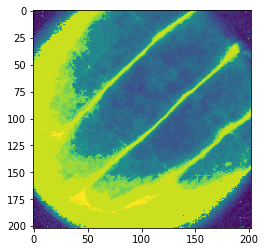

In [34]:
# assign them from the provided npy file
mel_true = Results_from_given_npy[:,:,4]
BlSDBN_true = Results_from_given_npy[:,:,10] 
# evaluate the same model on the HSI file located in Data_Mike folder
print(f'Test the trained Model from the Data_Mike/*.mat file for second evaluation...')
def evaluate_on_HSI(Hyperspectra_data_resized, 
                    melModel=trainedMelModel, 
                    BlsdbnModel=trainedBlSDBNModel):
    x_total, y_total, wavelenght = Hyperspectra_data_resized.shape # 202, 202, 21
    Hyperspectra_data_reshaped = Hyperspectra_data_resized.reshape(x_total*y_total, wavelenght)
    # Hyperspectra_data_reshaped = np.nan_to_num(Hyperspectra_data_reshaped.astype(np.float32))
    Hyperspectra_data_reshaped = np.nan_to_num(Hyperspectra_data_reshaped, nan=0.0, posinf=0.0, neginf=0.0)

    print(f"Reshaped Hyperspectra data shape : {Hyperspectra_data_reshaped.shape}")
    mel_pred = melModel.predict(Hyperspectra_data_reshaped)
    Blsdbn_pred = BlsdbnModel.predict(Hyperspectra_data_reshaped)
    
    mse_loss_mel = mse_loss(mel_pred, mel_true.reshape(x_total*y_total))
    mse_loss_Blsdbn = mse_loss(Blsdbn_pred, BlSDBN_true.reshape(x_total*y_total))
    print(f"mse loss for mel: {mse_loss_mel}")
    print(f"mse loss for Blsdbn: {mse_loss_Blsdbn}")
    
    # check whether these 2 predictions are the same
    # assert np.array_equal(mel_pred, Blsdbn_pred)==False, "The 2 predictions are the same"
    
    # reshape the prediction to the original shape
    return mel_pred.reshape(x_total, y_total), Blsdbn_pred.reshape(x_total, y_total)
    
melResult, BlsdbnResult = evaluate_on_HSI(Hyperspectra_data_resized)
plt.imshow(melResult)

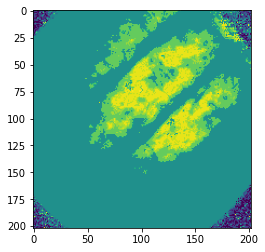

In [35]:
plt.imshow(BlsdbnResult)

`Try to use other color strategies.`

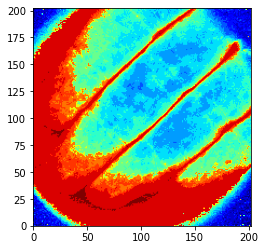

In [36]:
plt.imshow(melResult, extent=(0,x_total,0,y_total), cmap='jet')

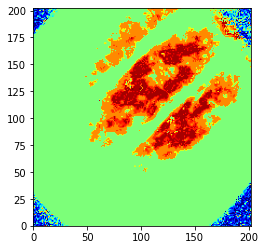

In [37]:
plt.imshow(BlsdbnResult, extent=(0,x_total,0,y_total), cmap='jet')


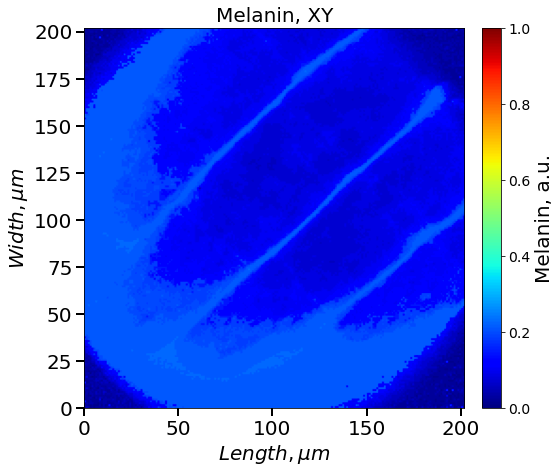

In [47]:
def plot_images(data, title):
    """ plot the images of the data, the code is directly from the given Plot.py file.
    """
    fig = plt.figure(figsize=(8,7));
    ax = fig.add_subplot(111);
    plot = ax.imshow(data, extent=(0,x_total,0,y_total), cmap='jet');
    ax.set_ylabel(r'$Width, \mu m$', fontsize=20);
    ax.set_xlabel(r'$Length, \mu m$', fontsize=20);
    ax.yaxis.set_ticks_position('left');
    ax.xaxis.set_ticks_position('bottom');
    ax.tick_params(axis='both',reset=False,which='both',length=8,width=2,labelsize=20);
    ax.set_title(f'{title}, XY', fontsize=20);
    plot.set_clim(vmin=0, vmax=1.0);
    cbar_blood_BlSDBN = fig.colorbar(plot, fraction=0.046, pad=0.04);
    cbar_blood_BlSDBN.set_label(f'{title}, a.u.',size=20);
    cbar_blood_BlSDBN.ax.tick_params(labelsize=14) ;
    plt.show();
    
    
plot_images(melResult, title = "Melanin")


In [ ]:
plot_images(BlsdbnResult, title = "BlSDBN")
